In [1731]:
import pyodbc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')

In [1732]:
# Connect to the Database
cnxn = pyodbc.connect("Driver={SQL Server Native Client 11.0};"
                        "Server=wd02;"
                        "Database=FootPrint;"
                        "Trusted_Connection=yes;")

# QUERY 01: Operations

In [1733]:
df = pd.read_sql_query("SELECT CONVERT(varchar,t.completedDateTime,100) Date, w.name warehouse, p.name project, oc.name operationCode, t.employee\
    FROM datex_footprint.Tasks t\
    JOIN datex_footprint.OperationCodes oc\
        ON oc.id = t.operationCodeId\
    JOIN datex_footprint.Warehouses w\
        ON w.id = t.warehouseId\
    JOIN datex_footprint.Projects p\
        ON p.id = t.projectId\
    WHERE (cast(t.completedDateTime as Date) = cast(getdate() as Date)) AND (t.employee != 'FootPrintService') AND (t.employee != 'Foot Print Service')\
    ORDER BY completedDateTime DESC", cnxn)

In [1734]:
# Adding Hours
df['Hour'] = pd.to_datetime(df['Date']).dt.hour
df.head()

,Date,warehouse,project,operationCode,employee,Hour
0,Mar 30 2022 8:14PM,10,"Senseonics, Incorporated",Scanned Shipment,Nelson Hurtado,20
1,Mar 30 2022 8:11PM,10,"Senseonics, Incorporated",Scanned Shipment,Nelson Hurtado,20
2,Mar 30 2022 8:05PM,10,"ACI Healthcare USA, Inc.",Scanned Shipment,Jackson Pierre,20
3,Mar 30 2022 7:59PM,10,"SD Head USA, LLC",Scanned Shipment,Andre Nau,19
4,Mar 30 2022 7:53PM,10,"Methapharm, Inc.",Batch Move,Carlos Gomez,19


# WAREHOUSE

In [1735]:
# Group By Warehouse
df_warehouse = df.groupby(['warehouse']).count()[['operationCode']]
df_warehouse.reset_index(inplace=True)
df_warehouse.head()

,warehouse,operationCode
0,10,1597
1,102,16
2,12,59
3,15,204
4,16,82


In [1736]:
# Pie Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.pie(activity, labels=warehouse)
#plt.show()

In [1737]:
# Bar Chart
warehouse = df_warehouse['warehouse']
activity = df_warehouse['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(warehouse, activity)
#plt.show()

In [1738]:
# Save Data in JSON format
df_warehouse_index = df_warehouse.set_index(['warehouse'])
df_warehouse_index.to_json('data/warehouse.json')
df_warehouse_index.head()

,operationCode
warehouse,
10,1597
102,16
12,59
15,204
16,82


### All Operations type

In [1739]:
df_operation = df.groupby(['operationCode']).count()[['project']]
df_operation.reset_index(inplace=True)
df_operation.head()

,operationCode,project
0,Batch Move,102
1,Count,65
2,Create Inventory,14
3,DONE RECEIVING,13
4,DRIVER CHECK IN,53


In [1740]:
# Horizontal Bar Chart
values = df_operation['project']
operation = df_operation['operationCode']

#plt.subplots(figsize=(8,8))
#plt.barh(operation, values)
#plt.gca().invert_yaxis()
#plt.show()

In [1741]:
df_operation.rename(columns={"project": "Tasks"})
df_operation.head()

,operationCode,project
0,Batch Move,102
1,Count,65
2,Create Inventory,14
3,DONE RECEIVING,13
4,DRIVER CHECK IN,53


In [1742]:
# Save Data in JSON format
df_operation = df_operation.rename(columns={"project": "Tasks"})
df_operation_index = df_operation.set_index(['operationCode'])
df_operation_index.to_json('data/operations_type.json')
df_operation_index.head()

,Tasks
operationCode,
Batch Move,102
Count,65
Create Inventory,14
DONE RECEIVING,13
DRIVER CHECK IN,53


### Excluding Operations PICKING and RECEIVING

In [1743]:
df_operation_excluded = df_operation.loc[(df_operation["operationCode"] != 'Picking') &
                                         (df_operation["operationCode"] != 'Receiving')]

In [1744]:
# Save Data in JSON format
df_operation_excluded = df_operation_excluded.rename(columns={"project": "Tasks"})
df_operation_excluded_index = df_operation_excluded.set_index(['operationCode'])
df_operation_excluded_index.to_json('data/operations_type_excluded.json')
df_operation_excluded_index.head()

,Tasks
operationCode,
Batch Move,102
Count,65
Create Inventory,14
DONE RECEIVING,13
DRIVER CHECK IN,53


### Operations per Hour

In [1745]:
df_hours = df.groupby(['Hour']).count()[['operationCode']]
df_hours.reset_index(inplace=True)
df_hours.head()

,Hour,operationCode
0,6,13
1,7,95
2,8,163
3,9,431
4,10,361


In [1746]:
# Bar Chart
hour = df_hours['Hour']
activity = df_hours['operationCode']

#plt.subplots(figsize=(8,8))
#plt.bar(hour, activity)
#plt.xticks(hour)
#plt.show()

In [1747]:
df_hours = df_hours.rename(columns={'operationCode': 'Operations'})
df_hours_index = df_hours.set_index(['Hour'])
df_hours_index.to_json('data/hours.json')
df_hours_index.head()

,Operations
Hour,
6,13
7,95
8,163
9,431
10,361


# PICKING

In [1748]:
# Filtered by Picking
df_picking = df[df['operationCode'] == 'Picking']

In [1749]:
# Grouped by Employee and Hour
df_picking_grouped = df_picking.groupby(['employee', 'Hour']).count()[['operationCode']]
df_picking_grouped.reset_index(inplace=True)
df_picking_grouped.head()

,employee,Hour,operationCode
0,Aisha Cooper,8,10
1,Aisha Cooper,9,12
2,Aisha Cooper,11,6
3,Aisha Cooper,12,10
4,Aisha Cooper,15,5


In [1750]:
# Pivot
df_picking_pivoted = df_picking_grouped.pivot(index='employee', columns='Hour', values='operationCode')
df_picking_pivoted = df_picking_pivoted.fillna(0)
df_picking_pivoted = df_picking_pivoted.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

df_picking_pivoted.head()

,7,8,9,10,11,12,13,14,15,16,17,18,19
employee,,,,,,,,,,,,,
Aisha Cooper,0.0,10.0,12.0,0.0,6.0,10.0,0.0,0.0,5.0,8.0,0.0,0.0,0.0
Alejandro Aguirre,0.0,0.0,0.0,0.0,0.0,0.0,13.0,8.0,0.0,0.0,0.0,0.0,0.0
Andre Nau,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,9.0,0.0,1.0,3.0,0.0
Angel Luna,0.0,2.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Baldomero Ramos,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


### Save in JSON File

In [1751]:
# Save into JSON
pickers = df_picking_pivoted.T
pickers.to_json('data/pickers.json')
pickers.head()

employee,Aisha Cooper,Alejandro Aguirre,Andre Nau,Angel Luna,Baldomero Ramos,Brad Bacchetti,Brittany Owen,Carlos Gomez,Carly Potts,Chris Martin,...,Reggie Bracken,Rita Geldres,Sandra Vega,Shannon Williamson,Shawn Saunders,Sujelin Soto-Orta,Wendy Medrano,William Trevino Trevino,Yaima Castillo,yudisel tubella
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,10.0,0.0,0.0,0.0
8,10.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,0.0,3.0,0.0,18.0,0.0,0.0,0.0
9,12.0,0.0,0.0,7.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,4.0,54.0,0.0,3.0,0.0
10,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,5.0,0.0,0.0,23.0,10.0,0.0,14.0,39.0
11,6.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,...,3.0,29.0,0.0,0.0,0.0,0.0,92.0,0.0,8.0,18.0


### Picking By Warehouse Function

In [1752]:
# Picking Function
def picking_by_warehouse (warehouse):
    # Filter by warehouse
    df_w = df_picking[df_picking['warehouse'] == warehouse]
    
    # Grouped by Employee and Hour
    df_w_group = df_w.groupby(['employee', 'Hour']).count()[['operationCode']]
    df_w_group.reset_index(inplace=True)
    
    # Pivot
    df_w_pivot = df_w_group.pivot(index='employee', columns='Hour', values='operationCode')
    df_w_pivot = df_w_pivot.fillna(0)
    df_w_pivot = df_w_pivot.rename_axis(None, axis=1)
    
    # Save into JSON
    pickers_df = df_w_pivot.T
    file_name = f'data/pickers_w{warehouse}.json'
    pickers_df.to_json(file_name)

In [1753]:
# Save warehouse data into JSON files
picking_by_warehouse('10')
picking_by_warehouse('12')
picking_by_warehouse('15')
picking_by_warehouse('16')
picking_by_warehouse('18')
picking_by_warehouse('19')
picking_by_warehouse('20')
picking_by_warehouse('21')
picking_by_warehouse('22')

# RECEIVING

In [1754]:
# Filtered by Picking
receiving_df = df[df['operationCode'] == 'Receiving']
receiving_df.head()

,Date,warehouse,project,operationCode,employee,Hour
38,Mar 30 2022 6:54PM,10,Livs Products,Receiving,Omar Robles,18
39,Mar 30 2022 6:54PM,10,Livs Products,Receiving,Djenyson Sanon,18
40,Mar 30 2022 6:54PM,10,Livs Products,Receiving,Djenyson Sanon,18
41,Mar 30 2022 6:54PM,10,Livs Products,Receiving,Omar Robles,18
42,Mar 30 2022 6:53PM,10,Livs Products,Receiving,Omar Robles,18


In [1755]:
# Grouped by Employee and Hour
receiving_group_df = receiving_df.groupby(['employee', 'Hour']).count()[['operationCode']]
receiving_group_df.reset_index(inplace=True)
receiving_group_df.head()

,employee,Hour,operationCode
0,Angela Pena,8,1
1,Angela Pena,9,1
2,Angela Pena,10,3
3,Carlos Chavez,7,8
4,Carlos Chavez,8,11


In [1756]:
# Pivot
receiving_pivot_df = receiving_group_df.pivot(index='employee', columns='Hour', values='operationCode')
receiving_pivot_df = receiving_pivot_df.fillna(0)
receiving_pivot_df = receiving_pivot_df.rename_axis(None, axis=1)
#df_picking_pivoted.reset_index(inplace=True)

receiving_pivot_df.head()

,6,7,8,9,10,11,12,13,14,15,16,17,18
employee,,,,,,,,,,,,,
Angela Pena,0.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Carlos Chavez,0.0,8.0,11.0,5.0,0.0,0.0,0.0,0.0,6.0,21.0,0.0,0.0,0.0
Casey Brown,0.0,0.0,0.0,0.0,0.0,39.0,24.0,0.0,35.0,0.0,0.0,0.0,0.0
Chris Martin,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Djenyson Sanon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,0.0,6.0,7.0


In [1757]:
# Save into JSON
receivers = receiving_pivot_df.T
receivers.to_json('data/receivers.json')
receivers.head()

employee,Angela Pena,Carlos Chavez,Casey Brown,Chris Martin,Djenyson Sanon,Hector Gonzalez,Hernando Sanchez,Juan Morales,Justin Runsdorf,Maria Ramos,Marzetta Bracken,Omar Robles,Reggie Bracken,Sandra Vega,Thalia Rivera,Tyler Gonzales,William Trevino Trevino,Yulieth Aguirre
6,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,8.0,0.0,50.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,11.0,0.0,0.0,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
9,1.0,5.0,0.0,0.0,0.0,3.0,20.0,40.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0
10,3.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# INVENTORY

In [1758]:
# Group By Operation Code and Warehouse
cycle_count_df = df.groupby(['operationCode', 'warehouse']).count()[['employee']]
cycle_count_df.reset_index(inplace=True)

In [1759]:
# Filtering by Count, Recount and Inventory Adjustment
cc_df = cycle_count_df.loc[(cycle_count_df["operationCode"] == 'Count') |
                           (cycle_count_df["operationCode"] == 'Recount') |
                           (cycle_count_df["operationCode"] == 'Inventory Adjustment')]

cc_df = cc_df.rename(columns={'employee': 'count'})

In [1760]:
cc_df_pivot = cc_df.pivot(index='operationCode', columns='warehouse', values='count')
cc_df_pivot = cc_df_pivot.fillna(0)
cc_df_pivot.to_json('data/cycle_count.json')
cc_df_pivot.head()

warehouse,10,102,12,15,16,20
operationCode,,,,,,
Count,18.0,0.0,0.0,26.0,0.0,21.0
Inventory Adjustment,11.0,11.0,12.0,0.0,1.0,0.0
Recount,2.0,0.0,0.0,0.0,0.0,0.0


# QUERY 02: Open Outbounds

In [1761]:
df_02 = pd.read_sql_query("SELECT DISTINCT w.name warehouse, p.name project, s.lookupCode shipment_number, s.createdSysDateTime\
    FROM datex_footprint.shipments s\
    LEFT JOIN datex_footprint.ShipmentOrderLookup sol\
        on sol.shipmentId = s.id\
    LEFT JOIN datex_footprint.orders o\
        on o.id = sol.orderId\
    LEFT JOIN datex_footprint.Projects p\
        on p.id = o.projectId\
    LEFT JOIN datex_footprint.warehouses w\
        on w.id = isnull(s.actualWarehouseId, s.expectedWarehouseId)\
    WHERE s.statusId in (1, 2, 4) and s.typeId = 2\
    ORDER BY createdSysDateTime", cnxn)

In [1762]:
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447


In [1763]:
df_02['age_order'] = pd.Timestamp.now() - df_02['createdSysDateTime']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1708 days 11:08:39.331196
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,912 days 09:27:38.385196
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,867 days 03:41:03.735196
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,798 days 06:57:35.465196
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,798 days 06:57:35.081196


In [1764]:
df_02['age_order_days'] = df_02['age_order'].dt.components['days']
df_02['age_order_hours'] = df_02['age_order'].dt.components['hours']
df_02.head()

,warehouse,project,shipment_number,createdSysDateTime,age_order,age_order_days,age_order_hours
0,17,"TherapeuticsMD, Inc.",489832,2017-07-26 09:09:09.197,1708 days 11:08:39.331196,1708,11
1,19,"Novadoz Pharmaceuticals, LLC",1901075,2019-09-30 10:50:10.143,912 days 09:27:38.385196,912,9
2,10,"Chadwick Pharmaceuticals, Inc.",2167054,2019-11-14 16:36:44.793,867 days 03:41:03.735196,867,3
3,10,Eywa Pharma Inc.,2475492,2020-01-22 13:20:13.063,798 days 06:57:35.465196,798,6
4,10,Eywa Pharma Inc.,2475493,2020-01-22 13:20:13.447,798 days 06:57:35.081196,798,6


In [1765]:
bins =[-1,1,2,3,7,30,60, 90,365, 730,10000]
bin_names = ['24 Hours', '48 Hours', '72 Hours', '1 Week', '1 Month', '2 Months', '3 Months', '1 Year', '2 Years', 'More than 2 years']

df_02['age_group'] = pd.cut(df_02['age_order_days'], bins, labels=bin_names)

In [1766]:
df_02_grouped = df_02.groupby(['age_group'])[['project']].count()

In [1767]:
df_02_grouped = df_02_grouped.rename(columns={'project': 'orders'})

In [1768]:
df_02_grouped

,orders
age_group,
24 Hours,803
48 Hours,230
72 Hours,60
1 Week,338
1 Month,1246
2 Months,637
3 Months,639
1 Year,2206
2 Years,1003


### Save in JSON File

In [1769]:
open_outbounds = df_02_grouped
open_outbounds.to_json('data/open_outbounds.json')
open_outbounds

,orders
age_group,
24 Hours,803
48 Hours,230
72 Hours,60
1 Week,338
1 Month,1246
2 Months,637
3 Months,639
1 Year,2206
2 Years,1003


<AxesSubplot:ylabel='age_group'>

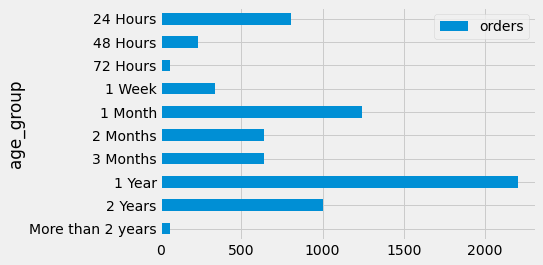

In [1770]:
df_02_grouped = df_02_grouped.iloc[::-1]
df_02_grouped.plot.barh()

In [1771]:
# Close connection
cnxn.close()